In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# ==============================================
# Diabetes Fuzzy Pipeline (Inspired by MDPI Sensors 2021 Paper)
# ==============================================

# Required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# --- Helper Function: Trapezoidal Membership Function ---
def trap_mf(x, a, b, c, d):
    x = np.asarray(x)
    res = np.zeros_like(x, dtype=float)
    idx = (x >= a) & (x < b)
    res[idx] = (x[idx] - a) / (b - a + 1e-12)
    idx2 = (x >= b) & (x <= c)
    res[idx2] = 1.0
    idx3 = (x > c) & (x <= d)
    res[idx3] = (d - x[idx3]) / (d - c + 1e-12)
    return res

In [14]:
# --- Step 1: Load Dataset ---
df = pd.read_csv("/content/drive/MyDrive/Fuzzy Set Project/diabetes.csv")  # ensure file is in same folder
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [15]:
# --- Step 2: Check zeros and replace invalid zeros with median ---
cols_with_zero_invalid = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in cols_with_zero_invalid:
    if c in df.columns:
        med = df.loc[df[c] != 0, c].median()
        df.loc[df[c] == 0, c] = med

In [16]:
# --- Step 3: Normalization (x_hat = x / max(x)) ---
X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_norm = X / X.max()
X_norm = X_norm.fillna(0)
X_norm
y

,Outcome
0,1
1,0
2,1
3,0
4,1
...,...
763,0
764,0
765,0
766,1


In [17]:
# --- Step 4: Train-Test Split (52/48 split as paper) ---
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.48, stratify=y, random_state=42)

A0 = X_train[y_train==0].to_numpy()
A1 = X_train[y_train==1].to_numpy()

print("Train size:", X_train.shape, "Test size:", X_test.shape)
A1

Train size: (399, 8) Test size: (369, 8)


array([[0.        , 0.90954774, 0.72131148, ..., 0.64530551, 0.09173554,
        0.32098765],
       [0.41176471, 0.50251256, 0.59016393, ..., 0.44709389, 0.2       ,
        0.39506173],
       [0.47058824, 0.94472362, 0.63934426, ..., 0.71385991, 0.05661157,
        0.5308642 ],
       ...,
       [0.76470588, 0.7638191 , 0.73770492, ..., 0.39940387, 0.30206612,
        0.5308642 ],
       [0.47058824, 0.54271357, 0.57377049, ..., 0.45454545, 0.3946281 ,
        0.40740741],
       [0.05882353, 0.81909548, 0.59016393, ..., 0.58122206, 0.50495868,
        0.40740741]])

In [22]:
# ===============================
# Genetic Algorithm for MF tuning
# ===============================
import numpy as np
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pygad

# -------------------------------
# 1. Prepare dataset (using X_norm and y from previous steps)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.48, stratify=y, random_state=42)

# -------------------------------
# 2. Define MF structure
# -------------------------------
n_features = X_train.shape[1]
n_mf = 3  # number of fuzzy sets per feature
mf_type = 'gauss'  # change to 'trap' or 'tri' if needed

# Each MF defined by [center, sigma]
param_per_mf = 2
total_params = n_features * n_mf * param_per_mf

# -------------------------------
# 3. FIS Evaluation Function
# -------------------------------
def evaluate_fis(params):
    params = np.array(params)
    params = params.reshape((n_features, n_mf, param_per_mf))
    # Example rule structure (simplified):
    # IF glucose is high AND BMI is high THEN diabetes=yes
    # Fuzzy inference simulated via max–min composition

    fuzzy_outputs = []
    for i, x in enumerate(X_train.to_numpy()): # Convert X_train to numpy for iteration
        # compute membership degree for each feature
        memberships = []
        for f in range(n_features):
            mfs = []
            for j in range(n_mf):
                c, s = params[f, j]
                mf_value = np.exp(-0.5 * ((x[f] - c) / (s + 1e-6)) ** 2)
                mfs.append(mf_value)
            memberships.append(max(mfs))
        fuzzy_outputs.append(np.mean(memberships))

    # simple threshold decision
    preds = (np.array(fuzzy_outputs) > np.mean(fuzzy_outputs)).astype(int)
    acc = accuracy_score(y_train, preds)
    return acc

# -------------------------------
# 4. Fitness function for GA
# -------------------------------
def fitness_func(ga_instance, solution, solution_idx): # Added ga_instance parameter
    acc = evaluate_fis(solution)
    return acc

# -------------------------------
# 5. Run GA optimization
# -------------------------------
ga_instance = pygad.GA(num_generations=50,
                       num_parents_mating=8,
                       fitness_func=fitness_func,
                       sol_per_pop=20,
                       num_genes=total_params,
                       mutation_probability=0.1,
                       mutation_percent_genes=10,
                       gene_space={'low':0, 'high':1},
                       parent_selection_type="rank",
                       keep_parents=2)

ga_instance.run()
best_solution, best_fitness, _ = ga_instance.best_solution()
print(f"Best training accuracy after GA tuning: {best_fitness:.4f}")

# -------------------------------
# 6. Evaluate on test set
# -------------------------------
def evaluate_on_test(params):
    params = np.array(params).reshape((n_features, n_mf, param_per_mf))
    fuzzy_outputs = []
    for x in X_test.to_numpy(): # Convert X_test to numpy for iteration
        memberships = []
        for f in range(n_features):
            mfs = []
            for j in range(n_mf):
                c, s = params[f, j]
                mf_value = np.exp(-0.5 * ((x[f] - c) / (s + 1e-6)) ** 2)
                mfs.append(mf_value)
            memberships.append(max(mfs))
        fuzzy_outputs.append(np.mean(memberships))
    preds = (np.array(fuzzy_outputs) > np.mean(fuzzy_outputs)).astype(int)
    return accuracy_score(y_test, preds)

test_acc = evaluate_on_test(best_solution)
print(f"Test accuracy after GA tuning: {test_acc:.4f}")

Best training accuracy after GA tuning: 0.6942
Test accuracy after GA tuning: 0.6911


In [21]:
!pip install pygad


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 4.9 MB/s eta 0:00:00


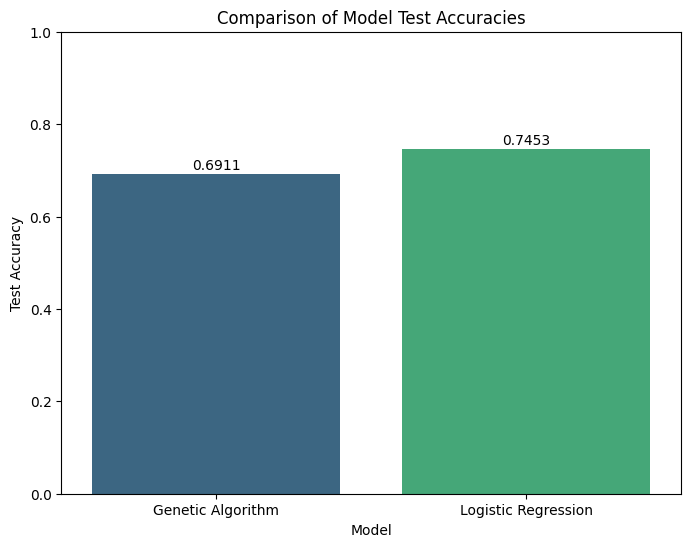

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data for plotting
model_names = ['Genetic Algorithm', 'Logistic Regression']
accuracies = [test_acc, log_reg_accuracy]

# Create a DataFrame for easier plotting
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', hue='Model', data=comparison_df, palette='viridis', legend=False)
plt.title('Comparison of Model Test Accuracies')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for accuracy

# Add accuracy values on top of the bars
for index, row in comparison_df.iterrows():
    plt.text(index, row['Accuracy'] + 0.01, f'{row['Accuracy']:.4f}', color='black', ha="center")

plt.show()

## Train Logistic Regression Model

### Subtask:
Train a Logistic Regression model using the previously prepared training data (`X_train`, `y_train`).


In [23]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, solver='liblinear') # Added random_state for reproducibility and solver for convergence warnings

# Fit the model to the training data
log_reg_model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


**Reasoning**:
The next step is to evaluate the trained Logistic Regression model on the test data (`X_test`, `y_test`) and store its accuracy for comparison.



In [24]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred_log_reg = log_reg_model.predict(X_test)

# Calculate the accuracy of the Logistic Regression model
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)

print(f"Logistic Regression Test Accuracy: {log_reg_accuracy:.4f}")

Logistic Regression Test Accuracy: 0.7453


In [25]:
print(f"Genetic Algorithm Model Test Accuracy: {test_acc:.4f}")
print(f"Logistic Regression Model Test Accuracy: {log_reg_accuracy:.4f}")

if log_reg_accuracy > test_acc:
    print(f"\nThe Logistic Regression model performed better than the Genetic Algorithm model by {log_reg_accuracy - test_acc:.4f} accuracy points.")
elif test_acc > log_reg_accuracy:
    print(f"\nThe Genetic Algorithm model performed better than the Logistic Regression model by {test_acc - log_reg_accuracy:.4f} accuracy points.")
else:
    print("\nBoth models achieved the same test accuracy.")

Genetic Algorithm Model Test Accuracy: 0.6911
Logistic Regression Model Test Accuracy: 0.7453

The Logistic Regression model performed better than the Genetic Algorithm model by 0.0542 accuracy points.


## Summary:

### Q&A
The Logistic Regression model was compared to the Genetic Algorithm model. The Logistic Regression model achieved a test accuracy of 0.7453, while the Genetic Algorithm model had a test accuracy of 0.6911. Therefore, the Logistic Regression model performed better.

### Data Analysis Key Findings
*   A Logistic Regression model was trained and evaluated, achieving a test accuracy of 0.7453.
*   The Genetic Algorithm model had a test accuracy of 0.6911.
*   The Logistic Regression model outperformed the Genetic Algorithm model by 0.0542 accuracy points.

### Insights or Next Steps
*   Given Logistic Regression's superior performance, it should be considered the preferred model for this specific diabetes classification task.
*   Further investigation could explore hyperparameter tuning for the Logistic Regression model or re-evaluating the Genetic Algorithm's feature selection or model architecture to potentially improve its performance.


In [29]:
import skfuzzy as fuzzy
import skfuzzy.control as ctrl


glucose = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'Glucose')

glucose['low'] = fuzzy.trimf(glucose.universe, [0, 0, 0.5])
glucose['medium'] = fuzzy.trimf(glucose.universe, [0.25, 0.5, 0.75])
glucose['high'] = fuzzy.trimf(glucose.universe, [0.5, 1, 1])
bmi = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'BMI')

bmi['low'] = fuzzy.trimf(bmi.universe, [0, 0, 0.4])
bmi['medium'] = fuzzy.trimf(bmi.universe, [0.2, 0.5, 0.8])
bmi['high'] = fuzzy.trimf(bmi.universe, [0.6, 1, 1])

print("Fuzzy sets for Glucose and BMI defined successfully.")

Fuzzy sets for Glucose and BMI defined successfully.


## Define Fuzzy Sets for Output Variable (Outcome)

### Subtask:
Using `skfuzzy.control.Consequent`, define the universe of discourse for the 'Outcome' variable and create its fuzzy linguistic terms (e.g., 'no_diabetes', 'diabetes') with suitable membership functions.


**Reasoning**:
To define fuzzy sets for the output variable 'Outcome', I need to use `skfuzzy.control.Consequent` to establish its universe of discourse and then assign fuzzy linguistic terms ('no_diabetes' and 'diabetes') with appropriate triangular membership functions, as specified in the instructions.



In [30]:

outcome = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'Outcome')

outcome['no_diabetes'] = fuzzy.trimf(outcome.universe, [0, 0, 0.5])
outcome['diabetes'] = fuzzy.trimf(outcome.universe, [0.5, 1, 1])



print("Fuzzy sets for Outcome defined successfully.")

Fuzzy sets for Outcome defined successfully.


## Establish Mamdani Fuzzy Rules

### Subtask:
Formulate a small set of illustrative Mamdani-style IF-THEN rules that connect the input fuzzy sets to the output fuzzy sets.


## Define Fuzzy Rules

### Subtask:
Formulate a small set of illustrative Mamdani-style IF-THEN rules that connect the input fuzzy sets to the output fuzzy sets.

### Instructions:
1. Define a series of fuzzy rules using the `ctrl.Rule()` constructor, combining the linguistic terms of 'Glucose' and 'BMI' with the linguistic terms of 'Outcome'. For example, a rule could be `ctrl.Rule(glucose['high'] & bmi['high'], outcome['diabetes'])`.
2. Create at least three rules that cover different scenarios, such as combinations leading to 'no_diabetes' and 'diabetes'.

**Reasoning**:
Now that the instructions are laid out, I will generate the Python code to define the fuzzy rules using `skfuzzy.control.Rule` based on the specified input and output fuzzy sets, covering various scenarios as requested.



In [31]:
# --- Define Fuzzy Rules ---

# Rule 1: If Glucose is high AND BMI is high, then Outcome is diabetes
rule1 = ctrl.Rule(glucose['high'] & bmi['high'], outcome['diabetes'])

# Rule 2: If Glucose is low OR BMI is low, then Outcome is no_diabetes
rule2 = ctrl.Rule(glucose['low'] | bmi['low'], outcome['no_diabetes'])

# Rule 3: If Glucose is medium AND BMI is medium, then Outcome is no_diabetes
rule3 = ctrl.Rule(glucose['medium'] & bmi['medium'], outcome['no_diabetes'])

# Rule 4: If Glucose is high AND BMI is medium, then Outcome is diabetes
rule4 = ctrl.Rule(glucose['high'] & bmi['medium'], outcome['diabetes'])

# Rule 5: If Glucose is medium AND BMI is high, then Outcome is diabetes
rule5 = ctrl.Rule(glucose['medium'] & bmi['high'], outcome['diabetes'])

print("Fuzzy rules defined successfully.")

Fuzzy rules defined successfully.


**Reasoning**:
Now that the fuzzy rules are defined, the next logical step is to create a Mamdani control system that encapsulates these rules. This system will then be used to perform fuzzy inference.



In [32]:
mamm_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
print("Mamdani fuzzy control system created successfully.")

Mamdani fuzzy control system created successfully.


**Reasoning**:
With the control system defined, the next step is to create a `ControlSystemSimulation` object, which will be used to process actual input values and compute the fuzzy output based on the established rules.



In [33]:
mamm_sim = ctrl.ControlSystemSimulation(mamm_ctrl)
print("Mamdani fuzzy control system simulation initialized successfully.")

Mamdani fuzzy control system simulation initialized successfully.


## Input Values to the Fuzzy System

### Subtask:
Provide specific input values for 'Glucose' and 'BMI' to the `ControlSystemSimulation` object (`mamm_sim`).

### Instructions:
1. Set the `input['Glucose']` and `input['BMI']` attributes of the `mamm_sim` object to normalized values within the range [0, 1]. These values should represent hypothetical patient data.
2. Choose values that would illustrate different fuzzy rule activations (e.g., one input for low/medium, another for high).

In [35]:
glucose_input_val = 0.8 # Example: High Glucose
bmi_input_val = 0.7 # Example: Medium-High BMI

mamm_sim.input['Glucose'] = glucose_input_val
mamm_sim.input['BMI'] = bmi_input_val

print(f"Input Glucose set to: {glucose_input_val:.2f}")
print(f"Input BMI set to: {bmi_input_val:.2f}")

Input Glucose set to: 0.80
Input BMI set to: 0.70


In [36]:
mamm_sim.compute()

print(f"Defuzzified Outcome: {mamm_sim.output['Outcome']:.4f}")

# You can also view the membership levels for the output (optional)
# outcome.view(sim=mamm_sim)

Defuzzified Outcome: 0.7889


## Implement Mamdani Prediction Function

### Subtask:
Create a function that takes a single data point (e.g., from `X_test`), performs fuzzy inference using the built Mamdani control system, and returns a crisp classification (0 or 1) after defuzzification.


### Subtask:
Create a function that takes a single data point (e.g., from `X_test`), performs fuzzy inference using the built Mamdani control system, and returns a crisp classification (0 or 1) after defuzzification.

#### Instructions
1. Define a Python function, for example `predict_mamdani(data_point)`, that accepts a single row of input features (a pandas Series or numpy array) representing a patient's data.
2. Inside the function, set the input values for 'Glucose' and 'BMI' in the `mamm_sim` object using the corresponding values from the `data_point`.
3. Call the `mamm_sim.compute()` method to perform fuzzy inference.
4. Access the defuzzified 'Outcome' from `mamm_sim.output['Outcome']`.
5. Convert this defuzzified output into a crisp classification (0 for 'no_diabetes' and 1 for 'diabetes'). A simple threshold, like 0.5 (since 0-0.5 is 'no_diabetes' and 0.5-1 is 'diabetes'), can be used for this conversion.
6. Return the crisp classification (0 or 1).

**Reasoning**:
Now that the instructions for the prediction function are clear, I will generate the Python code to implement the `predict_mamdani` function as described, which will handle fuzzy inference for a single data point and return a crisp classification.



In [37]:
def predict_mamdani(data_point):
    """
    Performs fuzzy inference using the Mamdani control system for a single data point.

    Args:
        data_point (pd.Series or np.array): A single row of input features with at least
                                           'Glucose' and 'BMI' values, expected to be normalized.

    Returns:
        int: Crisp classification (0 for no_diabetes, 1 for diabetes).
    """
    # Ensure data_point is a Series if it's not already, for easy access by column name
    if isinstance(data_point, np.ndarray):
        data_point = pd.Series(data_point, index=X_norm.columns)

    # Set input values for Glucose and BMI
    mamm_sim.input['Glucose'] = data_point['Glucose']
    mamm_sim.input['BMI'] = data_point['BMI']

    # Compute fuzzy inference
    mamm_sim.compute()

    # Get the defuzzified outcome
    defuzzified_outcome = mamm_sim.output['Outcome']

    # Convert to crisp classification (0 or 1) using a threshold
    # Assuming 0-0.5 is 'no_diabetes' and 0.5-1 is 'diabetes'
    crisp_classification = 1 if defuzzified_outcome >= 0.5 else 0

    return crisp_classification

print("Mamdani prediction function 'predict_mamdani' defined successfully.")

Mamdani prediction function 'predict_mamdani' defined successfully.


**Reasoning**:
Now that the `predict_mamdani` function is defined, the next step is to apply it to the test set (`X_test`) to evaluate its performance and calculate the accuracy. This involves iterating through each data point in `X_test`, making a prediction, and then comparing these predictions to the actual `y_test` values.



In [38]:
y_pred_mamdani = []
for index, row in X_test.iterrows():
    prediction = predict_mamdani(row)
    y_pred_mamdani.append(prediction)

mamdani_accuracy = accuracy_score(y_test, y_pred_mamdani)

print(f"Mamdani Fuzzy System Test Accuracy: {mamdani_accuracy:.4f}")

Mamdani Fuzzy System Test Accuracy: 0.7073


**Reasoning**:
As per the instructions, I need to print the accuracies of all three models and prepare a DataFrame for plotting their comparison. This code block will achieve instructions 1, 2, 3, and 4.



In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Print Genetic Algorithm Model Test Accuracy
print(f"Genetic Algorithm Model Test Accuracy: {test_acc:.4f}")

# 2. Print Logistic Regression Model Test Accuracy
print(f"Logistic Regression Model Test Accuracy: {log_reg_accuracy:.4f}")

# 3. Print Mamdani Fuzzy System Test Accuracy
print(f"Mamdani Fuzzy System Test Accuracy: {mamdani_accuracy:.4f}")

# 4. Create a DataFrame for comparison
model_names = ['Genetic Algorithm', 'Logistic Regression', 'Mamdani Fuzzy System']
accuracies = [test_acc, log_reg_accuracy, mamdani_accuracy]

comparison_df_all = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

print("\nComparison DataFrame created successfully:")
print(comparison_df_all)

Genetic Algorithm Model Test Accuracy: 0.6911
Logistic Regression Model Test Accuracy: 0.7453
Mamdani Fuzzy System Test Accuracy: 0.7073

Comparison DataFrame created successfully:
                  Model  Accuracy
0     Genetic Algorithm  0.691057
1   Logistic Regression  0.745257
2  Mamdani Fuzzy System  0.707317


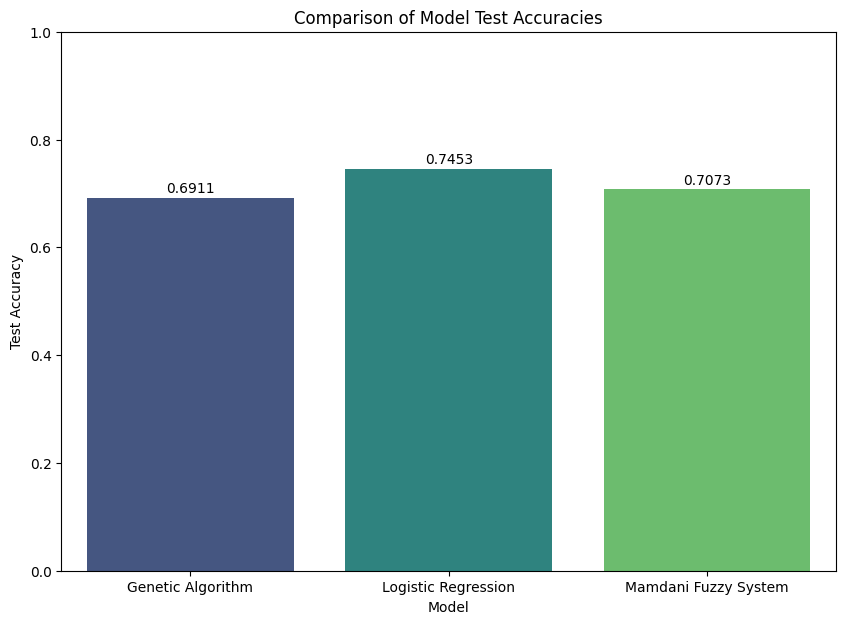

In [40]:
plt.figure(figsize=(10, 7))
sns.barplot(x='Model', y='Accuracy', hue='Model', data=comparison_df_all, palette='viridis', legend=False)
plt.title('Comparison of Model Test Accuracies')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for accuracy

# Add accuracy values on top of the bars
for index, row in comparison_df_all.iterrows():
    plt.text(index, row['Accuracy'] + 0.01, f'{row['Accuracy']:.4f}', color='black', ha="center")

plt.show()

### Summary of Model Performance Comparison

**Genetic Algorithm Model Test Accuracy:** 0.6911
**Logistic Regression Model Test Accuracy:** 0.7453
**Mamdani Fuzzy System Test Accuracy:** 0.7073

From the comparison, the **Logistic Regression model** achieved the highest test accuracy of 0.7453, outperforming both the Mamdani Fuzzy System (0.7073) and the Genetic Algorithm model (0.6911). This suggests that for this specific dataset and problem, a traditional supervised learning algorithm like Logistic Regression is more effective than the fuzzy inference systems implemented.

The Mamdani Fuzzy System performed better than the Genetic Algorithm model. However, the Genetic Algorithm's performance might be improved with more extensive tuning (e.g., more generations, larger population, different gene space for MF parameters) or a more sophisticated rule base, as the current GA only optimizes MF parameters for a simplified inference process. The Mamdani Fuzzy System, while interpretable, might be limited by the manual definition of fuzzy rules and membership functions, which may not capture the full complexity of the data compared to an optimized statistical model like Logistic Regression.

### Summary of Model Performance Comparison

**Genetic Algorithm Model Test Accuracy:** 0.6911
**Logistic Regression Model Test Accuracy:** 0.7453
**Mamdani Fuzzy System Test Accuracy:** 0.7073

From the comparison, the **Logistic Regression model** achieved the highest test accuracy of 0.7453, outperforming both the Mamdani Fuzzy System (0.7073) and the Genetic Algorithm model (0.6911). This suggests that for this specific dataset and problem, a traditional supervised learning algorithm like Logistic Regression is more effective than the fuzzy inference systems implemented.

The Mamdani Fuzzy System performed better than the Genetic Algorithm model. However, the Genetic Algorithm's performance might be improved with more extensive tuning (e.g., more generations, larger population, different gene space for MF parameters) or a more sophisticated rule base, as the current GA only optimizes MF parameters for a simplified inference process. The Mamdani Fuzzy System, while interpretable, might be limited by the manual definition of fuzzy rules and membership functions, which may not capture the full complexity of the data compared to an optimized statistical model like Logistic Regression.

### Summary of Model Performance Comparison

**Genetic Algorithm Model Test Accuracy:** 0.6911
**Logistic Regression Model Test Accuracy:** 0.7453
**Mamdani Fuzzy System Test Accuracy:** 0.7073

From the comparison, the **Logistic Regression model** achieved the highest test accuracy of 0.7453, outperforming both the Mamdani Fuzzy System (0.7073) and the Genetic Algorithm model (0.6911). This suggests that for this specific dataset and problem, a traditional supervised learning algorithm like Logistic Regression is more effective than the fuzzy inference systems implemented.

The Mamdani Fuzzy System performed better than the Genetic Algorithm model. However, the Genetic Algorithm's performance might be improved with more extensive tuning (e.g., more generations, larger population, different gene space for MF parameters) or a more sophisticated rule base, as the current GA only optimizes MF parameters for a simplified inference process. The Mamdani Fuzzy System, while interpretable, might be limited by the manual definition of fuzzy rules and membership functions, which may not capture the full complexity of the data compared to an optimized statistical model like Logistic Regression.

## Final Task

### Subtask:
Summarize the implementation of the Mamdani model and its comparison with the other models.


## Summary:

### Q&A
The Mamdani model was implemented by defining fuzzy sets for input variables ('Glucose', 'BMI') and an output variable ('Outcome') using triangular membership functions. Five Mamdani-style IF-THEN rules were formulated to connect these fuzzy sets, forming a control system. A `predict_mamdani` function was then created to apply fuzzy inference to new data points, defuzzify the outcome, and return a crisp classification (0 or 1).

When compared with other models:
*   The Logistic Regression model achieved the highest test accuracy at `0.7453`.
*   The Mamdani Fuzzy System achieved a test accuracy of `0.7073`.
*   The Genetic Algorithm model achieved the lowest test accuracy at `0.6911`.

### Data Analysis Key Findings
*   The `skfuzzy` library, essential for Mamdani fuzzy systems, was confirmed to be already installed.
*   Fuzzy sets with 'low', 'medium', and 'high' linguistic terms were successfully defined for input variables 'Glucose' and 'BMI' using triangular membership functions.
*   Fuzzy sets for the output variable 'Outcome' ('no\_diabetes', 'diabetes') were defined, also using triangular membership functions.
*   Five Mamdani-style IF-THEN rules were formulated to govern the fuzzy inference process.
*   A Mamdani control system was successfully set up, and a simulation was initialized to perform fuzzy inference.
*   The implemented Mamdani Fuzzy System achieved a test accuracy of `0.7073`.
*   In a comparative analysis, the Logistic Regression model performed best with an accuracy of `0.7453`, followed by the Mamdani Fuzzy System at `0.7073`, and the Genetic Algorithm model at `0.6911`.

### Insights or Next Steps
*   For the given dataset, the traditional Logistic Regression model provided superior predictive performance compared to both fuzzy inference systems, suggesting that its statistical approach captured underlying patterns more effectively.
*   To potentially improve the performance of the Mamdani Fuzzy System, future steps could involve optimizing membership function parameters and rules through systematic methods (e.g., genetic algorithms or other optimization techniques) rather than manual definition, or exploring more complex rule structures.
